In [77]:
# used to initialize os and per IAM permissions + imports
#
import matplotlib.pyplot as plt
from google.cloud import bigquery
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/vitorpedrosa/CLionProjects/Capstone/test1-339918-5b9c690dcff5.json"
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split

In [78]:
# Get Data from Big Query can be used to analyse results in either 5, 10. 15 or 30 minute intervals.
#

#queryString = """SELECT  TIMESTAMP_SECONDS(60*60 * DIV(UNIX_SECONDS(time), 60*60)) timekey, AVG(open) as open, AVG(high) as high, AVG(low) as low, AVG(close) as close FROM `test1-339918.btcusd_data.btcusd_final` GROUP BY timekey
     #;"""

queryString = """SELECT format_date("%Y-%m-%d", time) timekey, AVG(open) as open, AVG(high) as high, AVG(low) as low, AVG(close) as close FROM `test1-339918.btcusd_data.btcusd_final` GROUP BY timekey ORDER BY 1
 ;"""

bqclient = bigquery.Client()
data = (
    bqclient.query(queryString)

        .result()
        .to_dataframe(
        create_bqstorage_client=True,
    )
)
data.tail()

,timekey,open,high,low,close
185,2022-08-06,23192.803622,23196.936079,23188.319028,23192.540319
186,2022-08-07,23083.130784,23087.343185,23079.037807,23083.300430
187,2022-08-08,23399.562100,23406.211663,23394.678919,23400.880769
188,2022-10-10,19201.857132,19206.326176,19196.397647,19201.551912
189,2022-10-11,19077.840222,19082.571976,19072.802558,19077.729478


In [79]:
y_bar = data['close']
X = data.iloc[:,1:4]
X['close'] = y_bar

In [80]:
# Feature Scaling
#
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_fts = sc.fit_transform(X.values)
X_fts = pd.DataFrame(columns = X.columns, data = X_fts, index = X.index)

In [81]:
def lstm(data, steps):
    X, y = [], []
    for i in range (len(data) - steps + 1):
        X.append(data[i: i + steps, : -1])
        y.append(data[i + steps -1, -1])
    X_train, y_train = np.array(X), np.array(y)
    return X_train, y_train

In [82]:
import numpy as np
X1, y1 = lstm(X_fts.values, 2)
print(X1)
train_split = .8
split_index = int(np.ceil(len(X1) * train_split))
print(split_index)
print("-----")
date_index = X_fts.index
X_train, X_test = X1[:split_index], X1[split_index:]
y_train, t_test = y1[:split_index], y1[split_index:]
X_train_date, X_test_date = date_index[:split_index], date_index[split_index:]
print(X1.shape, X_train.shape, X_test.shape,y_bar.shape)

[[[ 0.53895132  0.5390017   0.5386227 ]
  [ 0.4312827   0.43120385  0.43143587]]

 [[ 0.4312827   0.43120385  0.43143587]
  [ 0.63717196  0.6378573   0.63714289]]

 [[ 0.63717196  0.6378573   0.63714289]
  [ 0.95492544  0.9546648   0.95517888]]

 ...

 [[-1.09060864 -1.09157978 -1.08964067]
  [-1.05554896 -1.05625702 -1.05466177]]

 [[-1.05554896 -1.05625702 -1.05466177]
  [-1.52064255 -1.52150074 -1.5199094 ]]

 [[-1.52064255 -1.52150074 -1.5199094 ]
  [-1.53438327 -1.53520965 -1.53360603]]]
152
-----
(189, 2, 3) (152, 2, 3) (37, 2, 3) (190,)


In [85]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
lstm_model = Sequential()
lstm_model.add(LSTM(units=32,return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 2, 32)             4608      
                                                                 
 dense (Dense)               (None, 2, 1)              33        
                                                                 
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


In [86]:
history = lstm_model.fit(X_train,y_train, epochs= 100, batch_size= 4, verbose=2, shuffle=False)

Epoch 1/100


2022-10-11 15:58:50.902163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


38/38 - 2s - loss: 0.9129 - 2s/epoch - 61ms/step
Epoch 2/100
38/38 - 0s - loss: 0.7527 - 397ms/epoch - 10ms/step
Epoch 3/100
38/38 - 0s - loss: 0.6194 - 374ms/epoch - 10ms/step
Epoch 4/100
38/38 - 0s - loss: 0.4413 - 384ms/epoch - 10ms/step
Epoch 5/100
38/38 - 0s - loss: 0.2533 - 376ms/epoch - 10ms/step
Epoch 6/100
38/38 - 0s - loss: 0.1659 - 366ms/epoch - 10ms/step
Epoch 7/100
38/38 - 0s - loss: 0.1490 - 364ms/epoch - 10ms/step
Epoch 8/100
38/38 - 0s - loss: 0.1351 - 364ms/epoch - 10ms/step
Epoch 9/100
38/38 - 0s - loss: 0.1197 - 373ms/epoch - 10ms/step
Epoch 10/100
38/38 - 0s - loss: 0.1027 - 471ms/epoch - 12ms/step
Epoch 11/100
38/38 - 0s - loss: 0.0844 - 439ms/epoch - 12ms/step
Epoch 12/100
38/38 - 0s - loss: 0.0669 - 358ms/epoch - 9ms/step
Epoch 13/100
38/38 - 0s - loss: 0.0536 - 366ms/epoch - 10ms/step
Epoch 14/100
38/38 - 0s - loss: 0.0449 - 369ms/epoch - 10ms/step
Epoch 15/100
38/38 - 0s - loss: 0.0387 - 345ms/epoch - 9ms/step
Epoch 16/100
38/38 - 0s - loss: 0.0339 - 348ms/epoc

In [107]:
y_pred = lstm_model.predict(X_test)
print(len(y_pred))

2/2 [==============================] - 0s 9ms/step
37


[-1.3553994]
[-1.3367457]
[-1.2822708]
[-1.1930875]
[-1.1992712]
[-1.2431219]
[-1.3053348]
[-1.3727936]
[-1.388401]
[-1.338454]
[-1.2818599]
[-1.2708886]
[-1.2395737]
[-1.1837635]
[-1.1186433]
[-1.0225787]
[-1.0694909]
[-1.0564253]
[-1.1101012]
[-1.1028175]
[-1.1637284]
[-1.2501445]
[-1.1999352]
[-1.0485284]
[-0.9883678]
[-0.97037077]
[-0.99561]
[-1.0424488]
[-1.0690993]
[-1.0530832]
[-1.0799419]
[-1.0630176]
[-1.0509046]
[-1.0595354]
[-1.0327175]
[-1.4137747]
[-1.4375194]


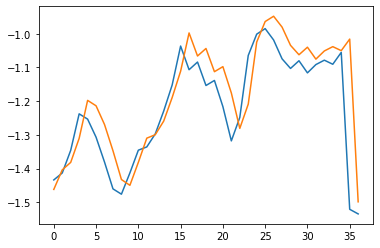

In [124]:
import matplotlib.pyplot as plt
plt.plot(t_test, label="True Value")
list = []
for i in range(len(y_pred)):
    print(y_pred[i][1])
    list.append(y_pred[i][0])
plt.plot(list, label="True Value")